# Working with EDI files and MTpy

This notebook shows how to load MT data from EDI files with [MTpy](https://github.com/MTgeophysics/mtpy) and convert EDI files into GoFEM inversion input.

Additionally, it shows how to use topography and coastline data and convert them from geographic to local rectangulat coordinates.

To run this notebook, along with MTpy you need to also have [cartopy](https://scitools.org.uk/cartopy/docs/latest/), [shapely](https://shapely.readthedocs.io/en/latest/project.html) and [geopandas](https://geopandas.org/) packages installed. All the packages can be installed via `conda install`

*Created by A. Grayver, 2020*

Let us start by including required python packages


In [4]:
import os
import sys
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas
import shapely
import cartopy.crs as ccrs

from shapely.geometry import Polygon, MultiPolygon, Point
from scipy.interpolate import RegularGridInterpolator
from netCDF4 import Dataset

%matplotlib inline

Next, let the python know where MTpy's python package lives and also include pyGoFEM tools:

In [2]:
# MTpy
sys.path.insert(0,'/home/agrayver/Documents/Progs/mtpy')
from mtpy.core.mt import MT
from mtpy.core.edi_collection import EdiCollection
from mtpy.utils.shapefiles_creator import ShapefilesCreator, plot_phase_tensor_ellipses_and_tippers
from mtpy.imaging.plotnresponses import PlotMultipleResponses

# GoFEM
module_path = os.path.abspath('../')
if module_path not in sys.path:
    sys.path.append(module_path)
    
from gofem.parameter_handler import *
from gofem.mesh_utils import *
from gofem.mtpy_utils import *

## Reading data

Read EDI files and display data.

In [9]:
edi_path = "./EDI/"
edi_files = glob.glob(os.path.normpath(os.path.abspath(os.path.join(edi_path, "*.edi"))))
edi_collection = EdiCollection(edi_files)

edi_collection.create_mt_station_gdf()

INFO:mtpy.core.edi_collection:number of edi files in this collection: 41


number of stations/edifiles = 41


INFO:mtpy.core.edi_collection:Number of MT Periods: 41


,StationId,Lon,Lat,Elev,UtmZone,geometry
0,M37,38.758608,7.739719,0.0,37N,POINT (38.75861 7.73972)
1,M18_1,38.795056,7.732567,0.0,37N,POINT (38.79506 7.73257)
2,M24,38.804139,7.825581,0.0,37N,POINT (38.80414 7.82558)
3,M19,38.815917,7.778597,0.0,37N,POINT (38.81592 7.77860)
4,M38,38.749392,7.739453,0.0,37N,POINT (38.74939 7.73945)
5,M34,38.776842,7.732767,0.0,37N,POINT (38.77684 7.73277)
6,M10,38.818497,7.787614,0.0,37N,POINT (38.81850 7.78761)
7,M13,38.811289,7.757828,0.0,37N,POINT (38.81129 7.75783)
8,M31,38.771797,7.816817,0.0,37N,POINT (38.77180 7.81682)
9,M22,38.800931,7.808917,0.0,37N,POINT (38.80093 7.80892)


In case you have a non-homogeneous frequency layout, you can easily interpolate your data to a common layout. We don't need this here.

In [2]:
# period list to interpolate onto
period_list = np.logspace(-2, 3, 20)

save_path = "./EDI_interpolated/"

for p in glob.iglob(os.path.join(save_path, '*.edi')):
    os.remove(p)

edi_collection.export_edi_files(save_path, 
                                period_list=period_list, # if not provided, will search edi files and find
                                                         # periods present in at least 10% of edis
                                period_buffer=2 # factor to stretch interpolation by. For example: if period_buffer=2
                                                # then interpolated data points will only be included if they are
                                                # within a factor of 2 of a true data point.
                                )

INFO:mtpy.core.edi_collection:number of edi files in this collection: 90


number of stations/edifiles = 90


INFO:mtpy.core.edi_collection:Number of MT Periods: 51
/home/agrayver/anaconda3/envs/gofem/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/agrayver/Documents/Progs/mtpy/mtpy/utils/calculator.py:365: RuntimeWarning: invalid value encountered in double_scalars
  z_rel_err = error/z_amp


It is easy to inspect individual stations:

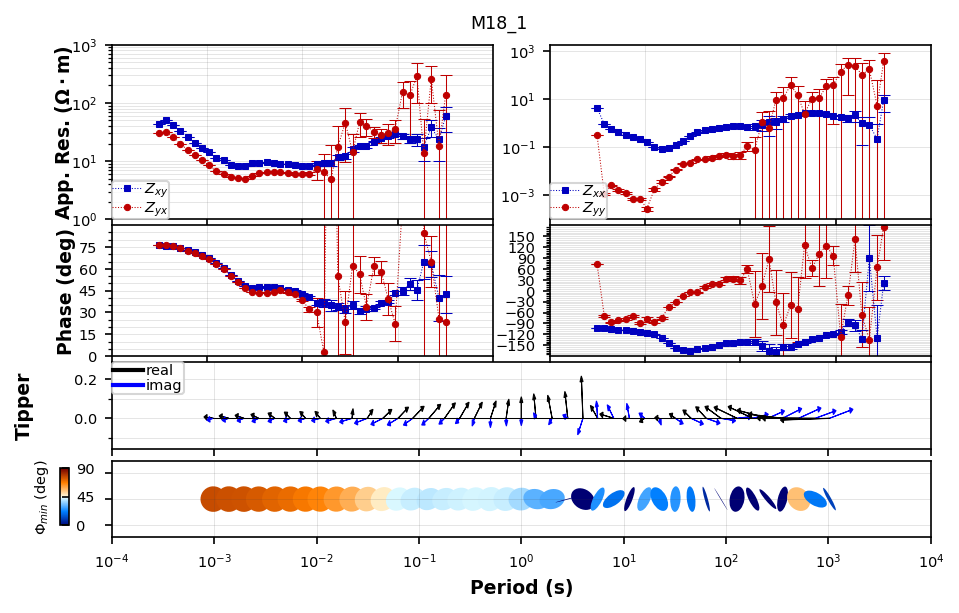

In [11]:
plot_obj = edi_collection.mt_obj_list[1].plot_mt_response(plot_num = 2, ploy_yn = 'y')

In [4]:
shpobj = ShapefilesCreator(edi_files, './VIC_interpolated')

period = 100
gdf_PT, _ = shpobj.create_phase_tensor_shp(period)
gdf_reT, _ = shpobj.create_tipper_real_shp(period)
gdf_imT, _ = shpobj.create_tipper_imag_shp(period)

INFO:mtpy.core.edi_collection:number of edi files in this collection: 90


number of stations/edifiles = 90


INFO:mtpy.core.edi_collection:Number of MT Periods: 16
INFO:mtpy.core.edi_collection:1,2,3,4 5 Percentile distances: 0.4792865244672283, 0.503551882069061, 0.5339367803553713, 0.6611691769895316, 0.7002524452639649


count    4005.000000
mean        3.026296
std         1.679948
min         0.354567
25%         1.636145
50%         2.704743
75%         4.116721
max         8.104458
dtype: float64
The plot period is  100


INFO:mtpy.core.edi_collection:Saved shapefile to ./VIC_interpolated/Period_100/Phase_Tensor_EPSG_4283_Period_100.shp
INFO:mtpy.core.edi_collection:Automatically Selected Max Tipper Length  = 0.4792865244672283
/home/agrayver/Documents/Progs/mtpy/mtpy/utils/calculator.py:365: RuntimeWarning: invalid value encountered in double_scalars
  z_rel_err = error/z_amp


The plot period is  100


/home/agrayver/anaconda3/envs/gofem/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
INFO:mtpy.core.edi_collection:Saved shapefile to ./VIC_interpolated/Period_100/Tipper_Real_EPSG_4283_Period_100.shp
INFO:mtpy.core.edi_collection:Automatically Selected Max-Tipper Length =: 0.4792865244672283
/home/agrayver/Documents/Progs/mtpy/mtpy/utils/calculator.py:365: RuntimeWarning: invalid value encountered in double_scalars
  z_rel_err = error/z_amp


The plot period is  100


/home/agrayver/anaconda3/envs/gofem/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
INFO:mtpy.core.edi_collection:Saved shapefile to ./VIC_interpolated/Period_100/Tipper_Imag_EPSG_4283_Period_100.shp


Create a geopandas data frame storing geometrical information about all stations:

In [5]:
gdf = edi_interpolated.create_mt_station_gdf()

/home/agrayver/anaconda3/envs/gofem/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Read and extract coasline data of the Australia. This will be used later to design a mesh:

In [6]:
df = geopandas.read_file('./data/ne_10m_admin_0_countries.shp')

is_au = df['NAME_EN'] == "Australia"
df_au = df[is_au]

Read bathymetry data:

In [7]:
nc_f = Dataset('./data/ETOPO1_Ice_c_gmt4.grd', 'r')

lon_etopo = np.array(nc_f.variables['x'][:])
lat_etopo = np.array(nc_f.variables['y'][:])
z_etopo = nc_f.variables['z'][:]

model_extent = [125, 165, -50, -25]
lon_idx = np.where((lon_etopo > model_extent[0]) & (lon_etopo < model_extent[1]))[0]
lat_idx = np.where((lat_etopo > model_extent[2]) & (lat_etopo < model_extent[3]))[0]

lon_etopo = lon_etopo[lon_idx]
lat_etopo = lat_etopo[lat_idx]

lon_grid, lat_grid = np.meshgrid(lon_etopo, lat_etopo, sparse=False, indexing='xy')

z_etopo = z_etopo[np.ix_(lat_idx, lon_idx)]

Plot shore line and stations:

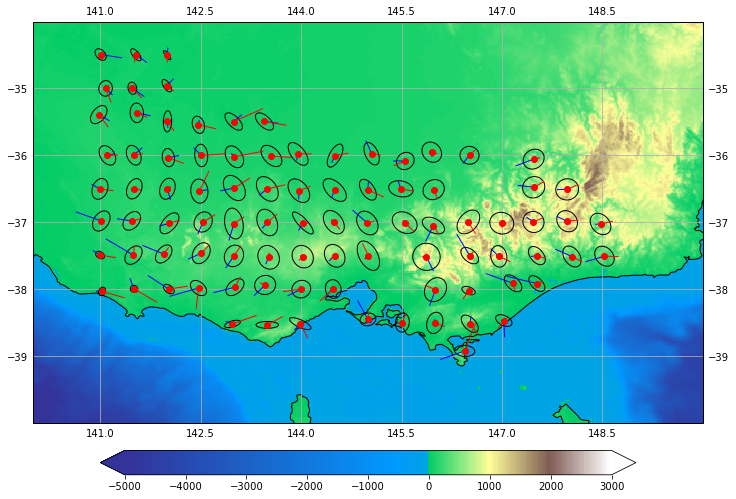

In [8]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([140, 150, -40, -34])
gl = ax.gridlines(draw_labels=True)

divnorm = colors.DivergingNorm(vmin=-5000, vcenter=0, vmax=3000)
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = colors.LinearSegmentedColormap.from_list('terrain_map',
    all_colors)

pcm = ax.pcolormesh(lon_etopo, lat_etopo, z_etopo, 
                    norm=divnorm, cmap = terrain_map)

cbar = fig.colorbar(pcm, ax = ax, extend='both', shrink=0.8, pad = 0.05, orientation='horizontal')
        
ax.add_geometries(df_au['geometry'], ccrs.PlateCarree(), facecolor='none',
                  edgecolor='black', zorder = 1)

ax.add_geometries(gdf_PT['geometry'], ccrs.PlateCarree(), facecolor='none',
                  edgecolor='black', zorder = 2)

ax.add_geometries(gdf_reT['tip_re'], ccrs.PlateCarree(),
                  edgecolor='b', zorder = 2)

ax.add_geometries(gdf_imT['tip_im'], ccrs.PlateCarree(),
                  edgecolor='r', zorder = 2)

ax.scatter(gdf['Lon'], gdf['Lat'], marker = 'o', color = 'r', zorder = 3)

#ax.set_aspect('equal', adjustable=None)

Convert all coordinates to the local rectangular frame centered at the survey. Remember we use coordinate system where Z points down, X points to the North and Y points to the East.

In [9]:
#crs = ccrs.AzimuthalEquidistant(central_longitude=144.5, central_latitude=-37.)
#crs = ccrs.TransverseMercator(central_longitude=144.5, central_latitude=-37.)
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=144.5, central_latitude=-37.)
y0, x0 = 0, 0

#crs = ccrs.UTM(54, southern_hemisphere=True)
#[x0, y0] = crs.transform_point(144.5, -37, ccrs.Geodetic())

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
df_cartesian = df_au.to_crs(crs_proj4)
gdf_cartesian = gdf.to_crs(crs_proj4)

au_poly = MultiPolygon([p for p in df_cartesian.iloc[0]['geometry'] if p.area > 1e9])
au_poly = shapely.ops.transform(lambda x, y: (y - y0, x - x0), au_poly)

x_st = []
y_st = []
[[y_st.append(p.x - x0), x_st.append(p.y - y0)] for p in gdf_cartesian['geometry']]

with open('./coastline.csv', 'w') as f:
    for geom in au_poly.geoms:
        x_au,y_au = geom.exterior.xy
        for n in range(len(x_au)):
            f.write("%0.6e %0.6e %0.6e\n" % (x_au[n], y_au[n], 0.1))
            
etopo_cart = crs.transform_points(ccrs.Geodetic(), lon_grid, lat_grid, z_etopo)

etopo_cart[:,:,0] -= x0
etopo_cart[:,:,1] -= y0

Plot evetything in the Cartesian frame:

(-1000000.0, 1000000.0)

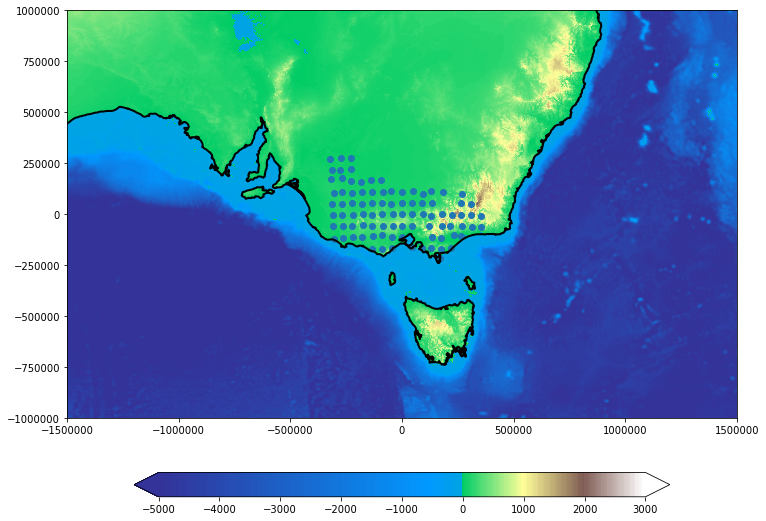

In [10]:
fig = plt.figure(figsize=(12, 10))
ax = plt.axes()

pcm = ax.pcolormesh(etopo_cart[:,:,0], etopo_cart[:,:,1], etopo_cart[:,:,2],\
                    norm=divnorm, cmap = terrain_map)

cbar = fig.colorbar(pcm, ax = ax, extend='both', shrink=0.8, pad = 0.1, orientation='horizontal')

for geom in au_poly.geoms:
    x_au,y_au = geom.exterior.xy
    ax.plot(y_au, x_au, color = 'k')
    
ax.scatter(y_st, x_st, marker = 'o')

ax.set_xlim([-1.5e6, 1.5e6])
ax.set_ylim([-1e6, 1e6])

### Mesh preparation

Let us start by creating a regular coarse mesh:

In [39]:
dx = np.ones(shape = 12) * 250000
dy = np.ones(shape = 8) * 250000
dz = np.array([400000, 300000, 200000, 100000, 60000, 60000, 100000, 200000, 300000, 400000])
mesh_size = np.array([np.sum(dy), np.sum(dx), np.sum(dz)])

p_origin = dealii.Point((-mesh_size / 2.).tolist())
p_end = dealii.Point((mesh_size / 2.).tolist())

triangulation = dealii.Triangulation('3D')
triangulation.generate_subdivided_steps_hyper_rectangle([dy.tolist(), dx.tolist(), dz.tolist()], p_origin, p_end, False)

str_fmt = '# of cells = %d\nsmallest cell = %0.1f m\nlargest cell = %0.1f m'

One of the most powerful features of GoFEM is locally refined meshes, which allow us to refine only in regions where it is needed, like at the air-ground interface. To do that, we first need to assign some physical properties to cells. We mark each cell with a material id. In particular, all cells above the ground are given material id one and the rest will have id two:

In [40]:
for cell in triangulation.active_cells():
    if cell.center().z < 0:
        cell.material_id = 1
    else:
        cell.material_id = 2

Now we define conductivity behind a material id. Also, we neglect displacement currents alltogether because of their irrelevance in the given periods range.

In [41]:
materials = {1: ('air', 1e-8), 2: ('ground', 0.01)}

# Switch to one if displacement currents are needed 
# (e.g., in case of RMT or GPR applications)
permittivity = 0.

Now refine at the air-ground interface:

In [42]:
#refine_at_interface(triangulation, material_ids = [2], repeat = 2)
#refine_at_interface(triangulation, material_ids = [2], repeat = 1,\
#                    center = [50000,30000,0], radii = [250000, 380000], pnorm = 1)

Refine along the coastline:

In [43]:
#refine_at_polygon_boundary(triangulation, polygon = au_poly,\
#                           material_id = 1, center = [500000, 0, 0],\
#                           radii = [750000, 1e7], repeat = 2, pnorm = 1)

#refine_at_polygon_boundary(triangulation, polygon = au_poly,\
#                           material_id = 1, center = [0, 0, 0],\
#                           radii = [300000, 600000], repeat = 1, pnorm = 1)

Now refine at the air-ground interface between the Victoria coast and the Tasmania:

In [44]:
#refine_at_interface(triangulation, material_ids = [2], repeat = 1,\
#                    center = [-500000,170000,0], radii = [250000, 200000], pnorm = 1)

#refine_at_interface(triangulation, material_ids = [2], repeat = 1,\
#                    center = [-370000,170000,0], radii = [125000, 175000], pnorm = 1)

print(str_fmt % (triangulation.n_active_cells(), 
                 triangulation.minimal_cell_diameter(),\
                 triangulation.maximal_cell_diameter()))

# of cells = 960
smallest cell = 358608.4 m
largest cell = 533853.9 m


Refine around MT stations:

In [45]:
receivers = []
for n in range(len(y_st)):
    receivers.append([x_st[n], y_st[n], 0.1])
    
refine_around_points(triangulation, points = receivers,\
                     center = [0, 0, 0], radii = [10000, 10000, 10000],\
                     repeat = 0, exclude_materials = [1])

Now, let us create a function that will take a point (e.g., grid cell center) in the projected coordinate system, transform it back to the geographic coordinates and infer the topography (as given by the ETOPO1 data set that we have read above):

In [46]:
crs_geo = ccrs.Geodetic()

topo_interpolant = RegularGridInterpolator((lat_etopo,lon_etopo), z_etopo, bounds_error = False)

def topofunc(p):
    p_geo = crs_geo.transform_point(p[1], p[0], crs)
    return -topo_interpolant([(p_geo[1], p_geo[0])])[0]

After generating the mesh, we actually assign materials to the sea cells. Since we work with a very large-scale model and will only model MT responses at periods longer than 10s, we will assign conductivity using an equivalent conductance. It is calculate as $\sigma = (h * 3.2) / dz$, where $h$ is sea depth and $dz$ is the vertical extent of the cell. The material is assigned only to the cells at the sea-air interface.

In [47]:
sea_conductivity = 3.2
minimum_conductivity = 0.05

air_material_id = 1
sea_material_id = 3
for cell in triangulation.active_cells():
    if cell.material_id == air_material_id:
        continue
                
    cell_center = cell.center().to_list()
    z_value = topofunc(cell_center)
    is_cell_inland = au_poly.contains(Point(cell_center[0], cell_center[1]))
    
    if is_cell_inland:
        continue
    
    for n, face in enumerate(cell.faces()):
        if not face.at_boundary():
            neighbor = cell.neighbor(n)
            if neighbor.material_id == air_material_id:
                cell.material_id = sea_material_id
                
                dz = cell.get_vertex(4).z - cell.get_vertex(0).z
                sigma = max((sea_conductivity * z_value) / dz, minimum_conductivity)
                
                materials[sea_material_id] = ('m%s' % sea_material_id, sigma)
                sea_material_id += 1

Let us add one more finel refinement:

In [48]:
#triangulation.refine_global(1)

print(str_fmt % (triangulation.n_active_cells(), 
                 triangulation.minimal_cell_diameter(),\
                 triangulation.maximal_cell_diameter()))

# of cells = 960
smallest cell = 358608.4 m
largest cell = 533853.9 m


Now, we will specify which cells are free inversion cells and which cells must be kept fixed. Specifically, all cells in the air and sea will be kept fixed.

In [49]:
free_domain_mask = []

subsurface_material_id = 2
for cell in triangulation.active_cells():
    if cell.material_id == subsurface_material_id:
        free_domain_mask.append([cell.level(), cell.index(), True])
    else:
        free_domain_mask.append([cell.level(), cell.index(), False])

Here is how our mesh looks like:

![title](vic_mesh.png)

Save mesh, materials and mask:

In [50]:
# save for ParaView visualization
triangulation.write('./model.vtu', 'vtu')

# save the mesh
triangulation.save('./gofem/model.tria')

# save the parameter mask
with open('./gofem/model.mask', 'w') as f:
    for parameter in free_domain_mask:
        f.write('%i %i %i\n' % (parameter[0], parameter[1], parameter[2]))

# save the material properties
with open('./gofem/model.materials', 'w') as f:
    f.write('# id name conductivity permitivitty\n')
    f.write('iso\n')
    for material_id, properties in materials.items():
        f.write("%d %s %0.6e %0.6e\n" % (material_id, properties[0], properties[1], permittivity))

Create receiver and frequency files that are necessary to run GoFEM:

In [51]:
with open('./gofem/receivers.csv', 'w') as f:
    f.write('# type name n_electrodes x y z\n')
    for n, name in enumerate(gdf_cartesian['StationId']):
        f.write("Dipole %s 1 %0.6e %0.6e %0.6e\n" % (name, x_st[n], y_st[n], 0.1))
        
frequencies = np.reciprocal(period_list)
np.savetxt('./gofem/frequencies', frequencies, header = '# frequency (Hz)')

Create a data file. Try `help(write_edi_collection_to_gofem)` to get more information about this function.

In [24]:
write_edi_collection_to_gofem(edi_interpolated,\
                              outfile = './gofem/invdata.dat',\
                              error_floor = 0.05,\
                              data_type = 'Z')

Specify a free parameter box. All cells within this box will be treated as free parameters in inversion provided they are also specified as free parameters by the mask defined above. For instance, if a cell is within this box and it is not an air or sea cell, the conductivity value will be inverted for in the inversion. All cells outside this box remain fixed.

In [25]:
point_begin = [-250000, -500000, 0]
point_end = [380000, 500000, 500000]

Finally, we need a parameter file:

In [26]:
prm = ParameterHandler(inversion = True, dim = 3)

# Let's use linear elements
prm.setitem(section = 'Modeling',\
            parameter = 'Order',\
            value = 1)
# Let's refine cells around receivers for further accuracy
prm.setitem(section = 'Modeling',\
            parameter = 'Refine cells around receivers',\
            value = 2)
# Set 2D boundary conditions
prm.setitem(section = 'Modeling',\
            parameter = 'BC',\
            value = 'Dirichlet2D')
# Let's calculate all frequencies in parallel
prm.setitem(section = 'Modeling',\
            parameter = 'Number of parallel frequencies',\
            value = len(frequencies))

# Solver options
prm.setitem(section = 'Solver',\
            parameter = 'Preconditioner',\
            value = 'Direct')

# Tell the code where to read all files from
prm.setitem(section = 'Model',\
            parameter = 'Model definition file',\
            value = '../model.tria')
prm.setitem(section = 'Model',\
            parameter = 'Materials definition file',\
            value = '../model.materials')
prm.setitem(section = 'Model',\
            parameter = 'Inversion model definition file',\
            value = '../model.tria')
prm.setitem(section = 'Model',\
            parameter = 'Inversion materials definition file',\
            value = '../model.materials')
prm.setitem(section = 'Model',\
            parameter = 'Active domain mask',\
            value = '../model.mask')
prm.setitem(section = 'Model',\
            parameter = 'Active domain box',\
            value = point_begin + point_end)

prm.setitem(section = 'Survey',\
            parameter = 'Frequencies file',
            value = '../frequencies')
prm.setitem(section = 'Survey',\
            parameter = 'Stations file',
            value = '../receivers.csv')

# Output parameters
prm.setitem(section = 'Output',\
            parameter = 'Type',
            value = 'point,volume')
prm.setitem(section = 'Output',\
            parameter = 'Data file',
            value = 'model')
prm.setitem(section = 'Output',\
            parameter = 'Parallel output',
            value = 'false')

# Inversion parameters
prm.setitem(section = 'Inversion',\
            parameter = 'Inversion input data',
            value = '../invdata.dat')
prm.setitem(section = 'Inversion',\
            parameter = 'Scaling factor',
            value = [0.01,])
prm.setitem(section = 'Inversion',\
            parameter = 'Regularization update',
            value = 100)
prm.setitem(section = 'Inversion',\
            parameter = 'Output files prefix',
            value = 'vic')

# Finally, write down the parameter file
prm.write('./gofem/input.prm')